In [ ]:
# # This audio classification tutorial, inspired by Nicholas Renotte in:
# # https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Load Dependencies

In [2]:
import os
import matplotlib
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Build Data Loading Function

### Define Paths to Files

In [3]:
CAPUCHIN_FILE = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC114131-1.wav'
NOT_CAPUCHIN_FILE ='/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-1.wav'

In [4]:
NOT_CAPUCHIN_FILE

'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-1.wav'

CAPUCHIN_FILE

## Build Data Function

In [26]:
# this function decodes our audio file
def load_wav_16k_mono(filename):
    # load encoded wav file
    file_contents = tf.io.read_file(filename)
    # decode wav (tensors by channel)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    # remove trailing axis
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # goes from 44.1kHz to 16kHz: amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [28]:
f_c = tf.io.read_file(CAPUCHIN_FILE)

In [29]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

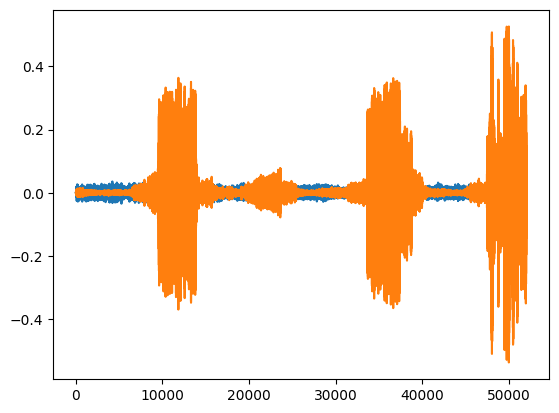

In [30]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [31]:
POS = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips')
NEG = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Not_Capuchinbird_Clips')

In [32]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [33]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [34]:
lengths = []
for file in os.listdir(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [35]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [37]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

In [38]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [39]:
spectrogram, label = preprocess(filepath, label)

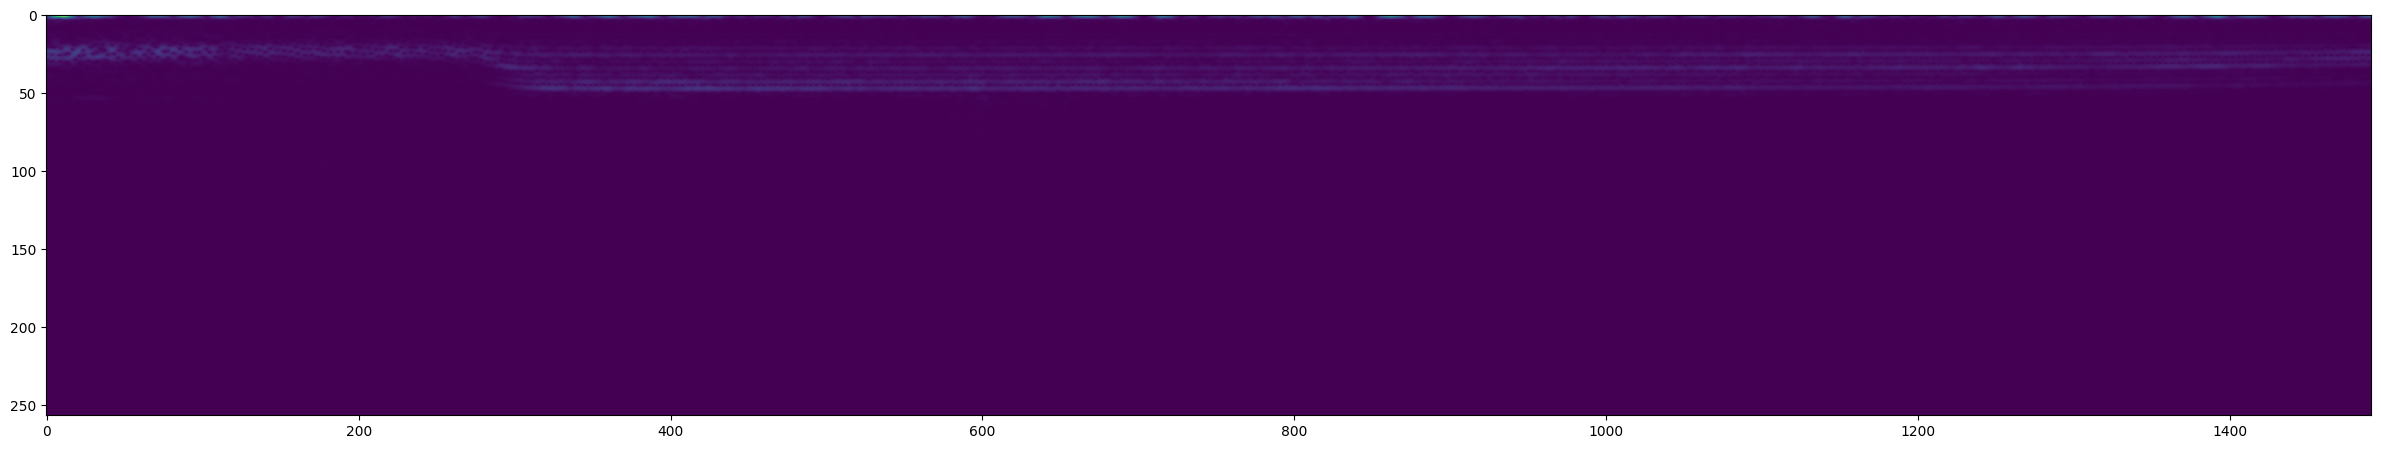

In [40]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [47]:
filepath0, label0 = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [48]:
spectrogram0, label0 = preprocess(filepath0, label0)

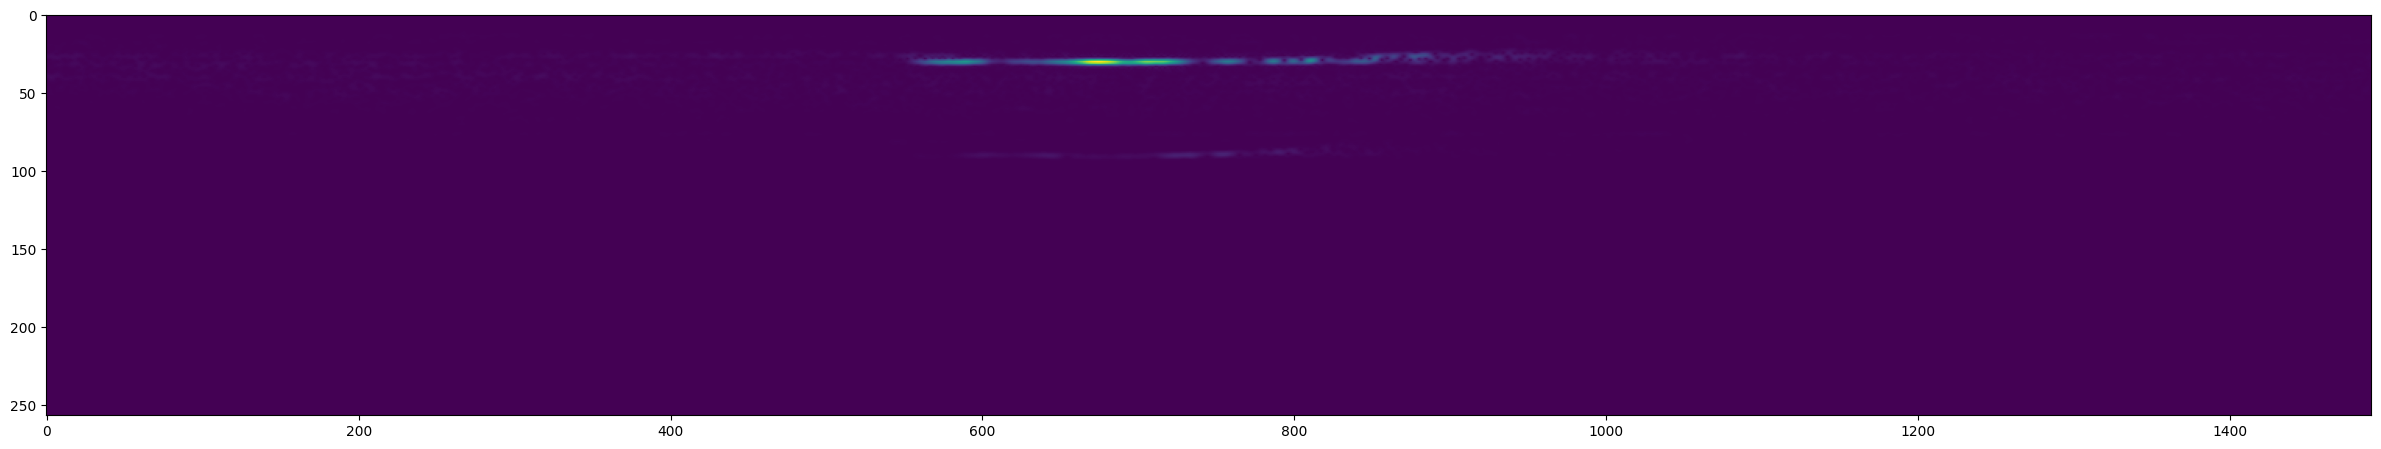

In [49]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram0)[0])
plt.show()

In [50]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [51]:
len(data)*0.7

35.699999999999996

In [53]:
train = data.take(36)
test = data.skip(36).take(15)

In [54]:
samples, labels = train.as_numpy_iterator().next()

In [55]:
samples.shape

(16, 1491, 257, 1)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [57]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [59]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [61]:
hist = model.fit(train, epochs=4, validation_data=test)



Epoch 1/4
36/36 [==============================] - 540s 15s/step - loss: 3.6906 - recall_1: 0.9028 - precision_1: 0.8609 - val_loss: 0.6601 - val_recall_1: 0.8421 - val_precision_1: 0.9796
Epoch 2/4
36/36 [==============================] - 533s 15s/step - loss: 0.1622 - recall_1: 0.9695 - precision_1: 0.9815 - val_loss: 0.0921 - val_recall_1: 0.9853 - val_precision_1: 1.0000
Epoch 3/4
36/36 [==============================] - 532s 15s/step - loss: 0.0465 - recall_1: 0.9858 - precision_1: 1.0000 - val_loss: 0.0814 - val_recall_1: 1.0000 - val_precision_1: 0.9714
Epoch 4/4
36/36 [==============================] - 531s 15s/step - loss: 0.0080 - recall_1: 0.9933 - precision_1: 0.9933 - val_loss: 0.0187 - val_recall_1: 0.9853 - val_precision_1: 1.0000


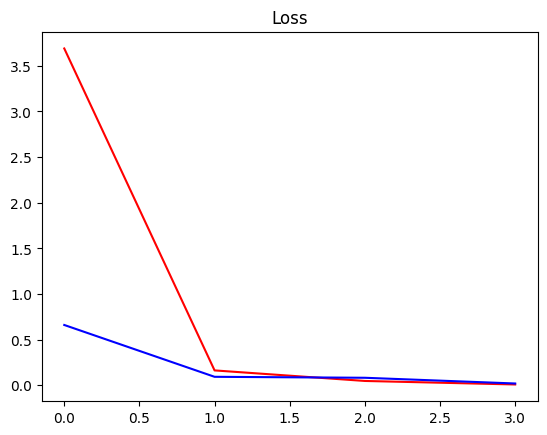

In [62]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

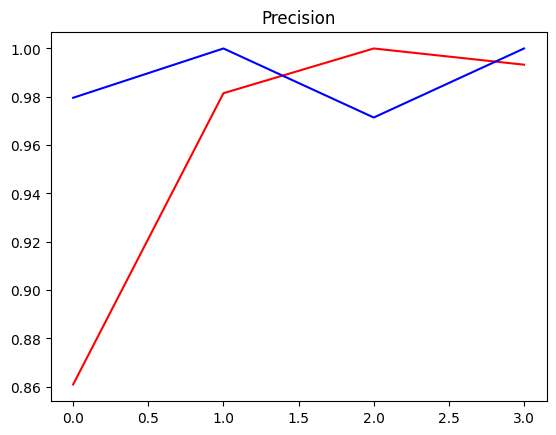

In [69]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

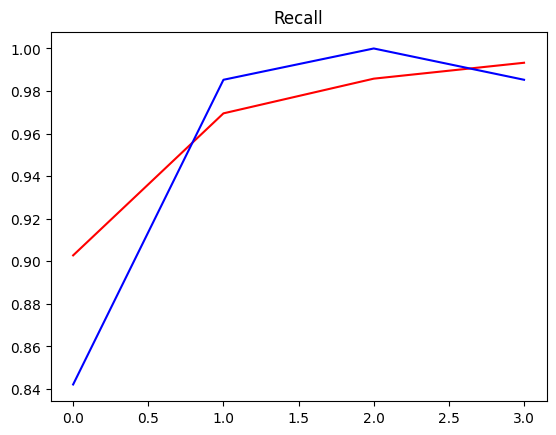

In [70]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

### Plot Wave

In [71]:
x_test, y_test = test.as_numpy_iterator().next()

In [72]:
yhat = model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [74]:
# pythonic for loop
yhat = [1 if prediction >0.5 else 0 for prediction in yhat]

In [75]:
def load_mp3_16k_mono(filename):
    # convert float tensor
    res = tfio.audio.AudioIOTensor(filename)
    # convert to tensor and combine channels
    tensor = res.to_tensor()
    # turn into single channel
    tensor = tf.math.reduce_sum(tensor, axis=1)/2
    
    # extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # resample to 16kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [76]:
mp3 = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', 'recording_00.mp3')

In [77]:
wav = load_mp3_16k_mono(mp3)

In [78]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [79]:
samples, index = audio_slices.as_numpy_iterator().next()

In [80]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram

In [81]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [82]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction >0.99 else 0 for prediction in yhat]

1/1 [==============================] - 8s 8s/step


In [83]:
from itertools import groupby

In [84]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [85]:
calls

5

In [86]:
results = {}

for file in os.listdir(os.path.join('../input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings')):
    FILEPATH = os.path.join('../input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 6s 6s/step


In [88]:
class_preds = {}

for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.999 else 0 for prediction in logits],

class_preds['recording_07.mp3']   

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],)

In [89]:
postprocessed={}
for file,scores in class_preds.items():
    postprocessed[file]=tf.math.reduce_sum([key for key,group in groupby(scores)]).numpy()

postprocessed

{'recording_76.mp3': 0,
 'recording_62.mp3': 0,
 'recording_48.mp3': 8,
 'recording_44.mp3': 2,
 'recording_45.mp3': 4,
 'recording_06.mp3': 10,
 'recording_43.mp3': 10,
 'recording_68.mp3': 1,
 'recording_95.mp3': 6,
 'recording_17.mp3': 58,
 'recording_65.mp3': 6,
 'recording_74.mp3': 0,
 'recording_10.mp3': 10,
 'recording_49.mp3': 0,
 'recording_15.mp3': 3,
 'recording_37.mp3': 7,
 'recording_64.mp3': 4,
 'recording_39.mp3': 59,
 'recording_04.mp3': 9,
 'recording_28.mp3': 59,
 'recording_05.mp3': 0,
 'recording_80.mp3': 2,
 'recording_57.mp3': 6,
 'recording_12.mp3': 0,
 'recording_59.mp3': 58,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 59,
 'recording_86.mp3': 59,
 'recording_47.mp3': 59,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 41,
 'recording_51.mp3': 4,
 'recording_35.mp3': 0,
 'recording_81.mp3': 8,
 'recording_30.mp3': 4,
 'recording_88.mp3': 0,
 'recording_75.mp3': 2,
 'rec

In [90]:
import csv

In [93]:
with open('capuchinbird_results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    
    for key, value in postprocessed.items():
        writer.writerow([key, value])